In [1]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import simulator
import generator

import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from joblib import Parallel, delayed

import scipy.stats as stats


In [2]:

# The objective is to find how many steps are needed to reach steady state

BIG_STEP_SIZE = 1000 # 100 steps
CHANNEL_RESERVED_FOR_HANDOVER = (0,1)

# results to collect are blocked, dropped, completed.

def run_simulations(
    seed, 
    channel_reserved_for_handover, 
    size_big_step,
    num_big_step,
) -> np.ndarray:
    results = np.zeros((num_big_step, 3), dtype=int)

    gen = generator.Generator(seed=seed)
    # Create a simulator object
    sim = simulator.Simulator(gen, channel_reserved_for_handover)

    for i in range(num_big_step):
        sim.run(size_big_step)
        # Collect results
        results[i, 0] = sim.dropped_calls
        results[i, 1] = sim.blocked_calls
        results[i, 2] = sim.completed_calls

    return results

    

In [3]:
# For finding the steady state step and termination step
NUM_BIG_STEPS = 100
NUMBER_OF_SIMULATIONS = 10
WINDOW_SIZE = int(NUM_BIG_STEPS / 10)

results = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS, 3), dtype=int)

for i, channel_reserved_for_handover in enumerate(CHANNEL_RESERVED_FOR_HANDOVER):
    desc = f"Simulations for reserved channel {channel_reserved_for_handover}"
    
    # Run simulations in parallel using joblib
    simulation_results = Parallel(n_jobs=NUMBER_OF_SIMULATIONS, verbose=10)(
        delayed(run_simulations)(
            j, channel_reserved_for_handover, BIG_STEP_SIZE, NUM_BIG_STEPS
        ) for j in range(NUMBER_OF_SIMULATIONS)
    )
    
    # Store results
    for j, result in enumerate(simulation_results):
        results[i, j] = result

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    7.9s remaining:   18.7s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    9.0s remaining:    3.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    9.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    5.8s remaining:   13.6s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    6.5s remaining:    6.5s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    6.9s remaining:    2.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    7.5s finished


Estimated steps until steady state:

Reserved channels: 0
Dropped calls: Step 20.0 (Simulation time: 20000.0 steps)
Blocked calls: Step 23.0 (Simulation time: 23000.0 steps)

Reserved channels: 1
Dropped calls: Step 25.0 (Simulation time: 25000.0 steps)
Blocked calls: Step 28.0 (Simulation time: 28000.0 steps)

Steady state steps to use: 28 big steps (28000 steps)
Termination step: 280 big steps (280000 steps)


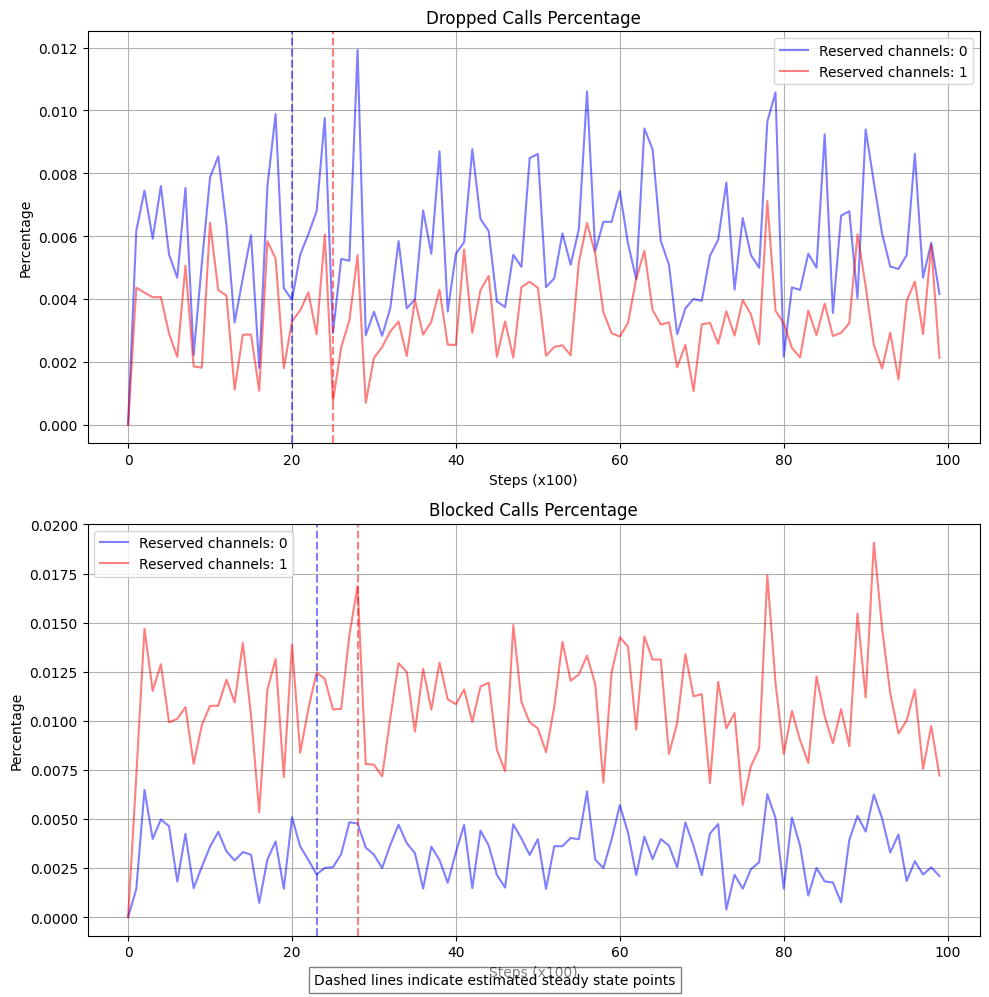

In [4]:

# get the section cnt of each blocked, dropped, completed calls, ie no_blocked_n - no_blocked_n-1
results_diff = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS, 3), dtype=int)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(1, NUM_BIG_STEPS):
            results_diff[i, j, k] = results[i, j, k] - results[i, j, k-1]

# make them into 2 percentages of the total number of calls
# ie blocked / (blocked + dropped + completed) and dropped / (blocked + dropped + completed)
results_diff_percentage = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS, 2), dtype=float)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(NUM_BIG_STEPS):
            total = results_diff[i, j, k, 0] + results_diff[i, j, k, 1] + results_diff[i, j, k, 2]
            if total > 0:
                results_diff_percentage[i, j, k, 0] = results_diff[i, j, k, 0] / total
                results_diff_percentage[i, j, k, 1] = results_diff[i, j, k, 1] / total

# plot the results for blocked and dropped calls (removing completed calls)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# Set steps for x-axis
steps = np.arange(NUM_BIG_STEPS)

# Plot dropped calls percentage for all simulations
colors = ['blue', 'red']
labels = ['Reserved channels: 0', 'Reserved channels: 1']

for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    # Average across all simulations
    dropped_pct = np.mean(results_diff_percentage[i, :, :, 0], axis=0)
    blocked_pct = np.mean(results_diff_percentage[i, :, :, 1], axis=0)
    
    # Plot dropped calls
    
    axs[0].plot(steps, dropped_pct, color=colors[i], label=labels[i], alpha=0.5)
    axs[0].set_title('Dropped Calls Percentage')
    axs[0].set_xlabel('Steps (x100)')
    axs[0].set_ylabel('Percentage')
    axs[0].legend()
    axs[0].grid(True)

    # Plot blocked calls
    axs[1].plot(steps, blocked_pct, color=colors[i], label=labels[i], alpha=0.5)
    axs[1].set_title('Blocked Calls Percentage')
    axs[1].set_xlabel('Steps (x100)')
    axs[1].set_ylabel('Percentage')
    axs[1].legend()
    axs[1].grid(True)

fig.tight_layout()

# Define a function to find the point of steady state
def find_steady_state_variance(data, window_size=10, var_ratio_tol=0.1):
    """
    Find the step where variance stabilizes (steady state).
    
    Parameters:
    - data: 1D array of metric values over time
    - window_size: number of steps to compare
    - var_ratio_tol: tolerance for variance ratio to be considered stable (e.g. ±10%)
    
    Returns:
    - index of steady state step
    """
    for i in range(window_size * 2, len(data)):
        early_window = data[i - 2*window_size : i - window_size]
        late_window = data[i - window_size : i]
        
        early_var = np.var(early_window)
        late_var = np.var(late_window)
        
        if early_var == 0:
            continue  # avoid divide-by-zero
        
        ratio = late_var / early_var
        
        if 1 - var_ratio_tol <= ratio <= 1 + var_ratio_tol:
            return i
    
    return len(data)



# Find steady state for each case
steady_states = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), 2))  # [dropped, blocked] for each reservation setting

STEADY_STATE_VARIANCE_THRESHOLD = 0.1 

for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    # Average across all simulations
    dropped_pct = np.mean(results_diff_percentage[i, :, :, 0], axis=0)
    blocked_pct = np.mean(results_diff_percentage[i, :, :, 1], axis=0)
    
    # Find steady state points
    steady_dropped = find_steady_state_variance(dropped_pct, WINDOW_SIZE, STEADY_STATE_VARIANCE_THRESHOLD)
    steady_blocked = find_steady_state_variance(blocked_pct, WINDOW_SIZE, STEADY_STATE_VARIANCE_THRESHOLD)
    
    steady_states[i, 0] = steady_dropped
    steady_states[i, 1] = steady_blocked

# Print the steps where steady state begins (in terms of steps and actual simulation time)
print("Estimated steps until steady state:")
for i, channels in enumerate(CHANNEL_RESERVED_FOR_HANDOVER):
    print(f"\nReserved channels: {channels}")
    print(f"Dropped calls: Step {steady_states[i, 0]} (Simulation time: {steady_states[i, 0] * BIG_STEP_SIZE} steps)")
    print(f"Blocked calls: Step {steady_states[i, 1]} (Simulation time: {steady_states[i, 1] * BIG_STEP_SIZE} steps)")

warm_up_time = int(max(steady_states[:, 0].max(), steady_states[:, 1].max()))
print(f"\nSteady state steps to use: {warm_up_time} big steps ({warm_up_time * BIG_STEP_SIZE} steps)")

# Add vertical lines to the plots indicating steady state points
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    axs[0].axvline(x=steady_states[i, 0], color=colors[i], linestyle='--', alpha=0.5)
    axs[1].axvline(x=steady_states[i, 1], color=colors[i], linestyle='--', alpha=0.5)

# Add a textbox explaining the dashed lines
fig.text(0.5, 0.01, 'Dashed lines indicate estimated steady state points', 
         ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

fig.savefig('diagrams/analysis_steady_state_analysis.png', dpi=300)
# Let the termination step = 10 * warmup time

termination_step = int(warm_up_time * 10)
print(f"Termination step: {termination_step} big steps ({termination_step * BIG_STEP_SIZE} steps)")

# Finding number of runs to achieve
gemma = 0.1

In [5]:
# Run 10 times with the warmup time and termination step
NUMBER_OF_SIMULATIONS = 10
# num_big_steps = termination_step
NUM_BIG_STEPS = termination_step + warm_up_time
num_warm_up_steps = warm_up_time

results = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS, 3), dtype=int)

for i, channel_reserved_for_handover in enumerate(CHANNEL_RESERVED_FOR_HANDOVER):
    desc = f"Simulations for reserved channel {channel_reserved_for_handover}"
    # Run simulations in parallel using joblib
    simulation_results = Parallel(n_jobs=NUMBER_OF_SIMULATIONS, verbose=10)(
        delayed(run_simulations)(
            j, channel_reserved_for_handover, BIG_STEP_SIZE, NUM_BIG_STEPS
        ) for j in range(NUMBER_OF_SIMULATIONS)
    )
    
    # Store results
    for j, result in enumerate(simulation_results):
        results[i, j] = result

# remove the warmup time from the results
results = results[:, :, num_warm_up_steps:, :]

# get the section cnt of each blocked, dropped, completed calls, ie no_blocked_n - no_blocked_n-1
results_diff = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS-num_warm_up_steps, 3), dtype=int)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(1, NUM_BIG_STEPS-num_warm_up_steps):
            results_diff[i, j, k] = results[i, j, k] - results[i, j, k-1]

# make them into 2 percentages of the total number of calls
# ie blocked / (blocked + dropped + completed) and dropped / (blocked + dropped + completed)
results_diff_percentage = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS-num_warm_up_steps, 2), dtype=float)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(NUM_BIG_STEPS-num_warm_up_steps):
            total = results_diff[i, j, k, 0] + results_diff[i, j, k, 1] + results_diff[i, j, k, 2]
            if total > 0:
                results_diff_percentage[i, j, k, 0] = results_diff[i, j, k, 0] / total
                results_diff_percentage[i, j, k, 1] = results_diff[i, j, k, 1] / total


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   17.0s remaining:   39.9s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:   19.0s remaining:   19.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   19.4s remaining:    8.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   19.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   16.8s remaining:   39.3s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:   18.1s remaining:   18.1s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   18.8s remaining:    8.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   19.5s finished


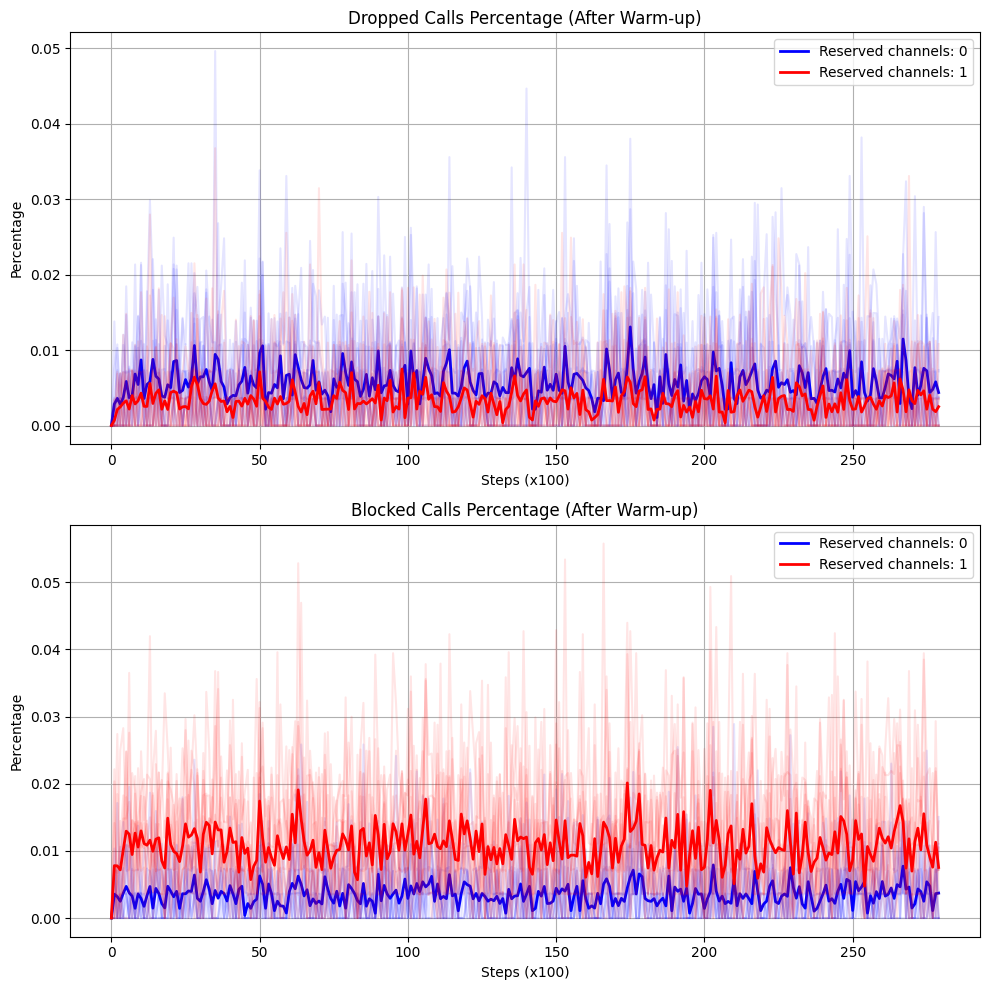

In [6]:
# plot the results for blocked and dropped calls (removing completed calls)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# Set steps for x-axis
steps = np.arange(NUM_BIG_STEPS-num_warm_up_steps)

# Plot dropped calls percentage for all simulations
colors = ['blue', 'red']
labels = ['Reserved channels: 0', 'Reserved channels: 1']
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    # Calculate average percentages across all simulations
    dropped_pct_avg = np.mean(results_diff_percentage[i, :, :, 0], axis=0)
    blocked_pct_avg = np.mean(results_diff_percentage[i, :, :, 1], axis=0)
    
    # Plot dropped calls percentages - both individual simulations and average
    for j in range(NUMBER_OF_SIMULATIONS):
        axs[0].plot(steps, results_diff_percentage[i, j, :, 0], color=colors[i], alpha=0.1)
    
    # Plot the average line with higher alpha
    axs[0].plot(steps, dropped_pct_avg, color=colors[i], label=labels[i], linewidth=2)
    axs[0].set_title('Dropped Calls Percentage (After Warm-up)')
    axs[0].set_xlabel('Steps (x100)')
    axs[0].set_ylabel('Percentage')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot blocked calls percentages - both individual simulations and average
    for j in range(NUMBER_OF_SIMULATIONS):
        axs[1].plot(steps, results_diff_percentage[i, j, :, 1], color=colors[i], alpha=0.1)
    
    # Plot the average line with higher alpha
    axs[1].plot(steps, blocked_pct_avg, color=colors[i], label=labels[i], linewidth=2)
    axs[1].set_title('Blocked Calls Percentage (After Warm-up)')
    axs[1].set_xlabel('Steps (x100)')
    axs[1].set_ylabel('Percentage')
    axs[1].legend()
    axs[1].grid(True)

fig.tight_layout()
fig.savefig('diagrams/analysis_steady_state_analysis_after_warmup.png', dpi=300)


In [7]:
# results_diff_percentage = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, num_big_steps-num_warm_up_steps, 2), dtype=float)
# Parameters
target_precision_beta = 0.002  # Target half-width of the confidence interval (precision)
confidence_level = 0.95       # Confidence level
pilot_sample_size = NUMBER_OF_SIMULATIONS

# Function to compute half-width (delta) from pilot data using t-distribution
def compute_half_width(pilot_data, confidence_level):
    n0 = len(pilot_data)
    sample_std = np.std(pilot_data, ddof=1)
    t_value = stats.t.ppf(1 - (1 - confidence_level) / 2, df=n0 - 1)
    delta = t_value * sample_std / np.sqrt(n0)
    return delta, sample_std

# Function to estimate total runs needed based on slide formula
def estimate_total_runs(n0, delta, beta):
    return int(np.ceil(n0 * (delta ** 2) / (beta ** 2)))

# Run estimation for each channel reservation setting
sample_sizes = np.zeros(len(CHANNEL_RESERVED_FOR_HANDOVER), dtype=int)

for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    # Get pilot sample (shape: [NUMBER_OF_SIMULATIONS, num_big_steps])
    data = results_diff_percentage[i, :, :, 0]  # 0 for blocked call percentage
    flat_data = data.flatten()
    
    # Use first n0 samples as pilot
    pilot_data = flat_data[:pilot_sample_size]
    
    # Compute delta and std from pilot
    delta, s_n0 = compute_half_width(pilot_data, confidence_level)
    
    # Estimate total number of runs required
    total_n = estimate_total_runs(pilot_sample_size, delta, target_precision_beta)
    
    sample_sizes[i] = total_n

# Print the results
print("Estimated sample sizes needed for each channel reservation setting:")
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    print(f"Reserved channels: {CHANNEL_RESERVED_FOR_HANDOVER[i]} - Sample size needed: {sample_sizes[i]}")

recomended_simulation_runs = sample_sizes.max()
print(f"Max sample size needed: {recomended_simulation_runs}")

Estimated sample sizes needed for each channel reservation setting:
Reserved channels: 0 - Sample size needed: 44
Reserved channels: 1 - Sample size needed: 22
Max sample size needed: 44


# FINAL RUN

In [8]:
# Run 10 times with the warmup time and termination step
# num_big_steps = termination_step
NUM_BIG_STEPS = termination_step
num_warm_up_steps = warm_up_time

NUMBER_OF_SIMULATIONS = sample_sizes.max()

TOTAL_PROCCESSORS = 16

print(f"Running {NUMBER_OF_SIMULATIONS * 2} simulations with {NUM_BIG_STEPS * BIG_STEP_SIZE} steps each")

results = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS, 3), dtype=int)

for i, channel_reserved_for_handover in enumerate(CHANNEL_RESERVED_FOR_HANDOVER):
    desc = f"Simulations for reserved channel {channel_reserved_for_handover}"
    # Run simulations in parallel using joblib
    simulation_results = Parallel(n_jobs=TOTAL_PROCCESSORS, verbose=10)(
        delayed(run_simulations)(
            j, channel_reserved_for_handover, BIG_STEP_SIZE, NUM_BIG_STEPS
        ) for j in range(NUMBER_OF_SIMULATIONS)
    )
    
    # Store results
    for j, result in enumerate(simulation_results):
        results[i, j] = result

# remove the warmup time from the results
results = results[:, :, num_warm_up_steps:, :]

# get the section cnt of each blocked, dropped, completed calls, ie no_blocked_n - no_blocked_n-1
results_diff = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS-num_warm_up_steps, 3), dtype=int)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(1, NUM_BIG_STEPS-num_warm_up_steps):
            results_diff[i, j, k] = results[i, j, k] - results[i, j, k-1]

# make them into 2 percentages of the total number of calls
# ie blocked / (blocked + dropped + completed) and dropped / (blocked + dropped + completed)
results_diff_percentage = np.zeros((len(CHANNEL_RESERVED_FOR_HANDOVER), NUMBER_OF_SIMULATIONS, NUM_BIG_STEPS-num_warm_up_steps, 2), dtype=float)
for i in range(len(CHANNEL_RESERVED_FOR_HANDOVER)):
    for j in range(NUMBER_OF_SIMULATIONS):
        for k in range(NUM_BIG_STEPS-num_warm_up_steps):
            total = results_diff[i, j, k, 0] + results_diff[i, j, k, 1] + results_diff[i, j, k, 2]
            if total > 0:
                results_diff_percentage[i, j, k, 0] = results_diff[i, j, k, 0] / total
                results_diff_percentage[i, j, k, 1] = results_diff[i, j, k, 1] / total

Running 88 simulations with 280000 steps each


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   28.8s
[Parallel(n_jobs=16)]: Done  18 out of  44 | elapsed:   48.1s remaining:  1.2min
[Parallel(n_jobs=16)]: Done  23 out of  44 | elapsed:   55.7s remaining:   50.9s
[Parallel(n_jobs=16)]: Done  28 out of  44 | elapsed:   58.5s remaining:   33.4s
[Parallel(n_jobs=16)]: Done  33 out of  44 | elapsed:  1.2min remaining:   23.9s
[Parallel(n_jobs=16)]: Done  38 out of  44 | elapsed:  1.3min remaining:   12.7s
[Parallel(n_jobs=16)]: Done  44 out of  44 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   29.0s
[Parallel(n_jobs=16)]: Done  18 out of  44 | elapsed:   48.7s remaining:  1.2min
[Parallel(n_jobs=16)]: Done  23 out of  44 | elapsed:   55.5s remaining:   50.7s
[Parallel(n_jobs=16)]: Done  28 out of  44 | elapsed:  1.0min remaining:   34.5s
[Pa

In [9]:
# Calculate means across all simulations for each channel reservation setting
mean_dropped_ho0 = np.mean(results_diff_percentage[0, :, :, 0], axis=0)
mean_blocked_ho0 = np.mean(results_diff_percentage[0, :, :, 1], axis=0)
mean_dropped_ho1 = np.mean(results_diff_percentage[1, :, :, 0], axis=0)
mean_blocked_ho1 = np.mean(results_diff_percentage[1, :, :, 1], axis=0)

# Calculate overall means
overall_dropped_ho0 = np.mean(mean_dropped_ho0)
overall_blocked_ho0 = np.mean(mean_blocked_ho0)
overall_dropped_ho1 = np.mean(mean_dropped_ho1)
overall_blocked_ho1 = np.mean(mean_blocked_ho1)

# Calculate confidence intervals using t-distribution
confidence = 0.95
def calculate_ci(data, confidence):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    t_value = stats.t.ppf((1 + confidence) / 2, n-1)
    interval = sem * t_value
    return mean, interval

# Flatten all simulation results for confidence interval calculation
dropped_ho0_flat = results_diff_percentage[0, :, :, 0].flatten()
blocked_ho0_flat = results_diff_percentage[0, :, :, 1].flatten()
dropped_ho1_flat = results_diff_percentage[1, :, :, 0].flatten()
blocked_ho1_flat = results_diff_percentage[1, :, :, 1].flatten()

# Calculate means and confidence intervals
dropped_ho0_mean, dropped_ho0_ci = calculate_ci(dropped_ho0_flat, confidence)
blocked_ho0_mean, blocked_ho0_ci = calculate_ci(blocked_ho0_flat, confidence)
dropped_ho1_mean, dropped_ho1_ci = calculate_ci(dropped_ho1_flat, confidence)
blocked_ho1_mean, blocked_ho1_ci = calculate_ci(blocked_ho1_flat, confidence)

# Print results
print(f"\nChannel Reservation = 0:")
print(f"Dropped calls: {dropped_ho0_mean:.4f} ± {dropped_ho0_ci:.4f} (95% CI)")
print(f"Blocked calls: {blocked_ho0_mean:.4f} ± {blocked_ho0_ci:.4f} (95% CI)")

print(f"\nChannel Reservation = 1:")
print(f"Dropped calls: {dropped_ho1_mean:.4f} ± {dropped_ho1_ci:.4f} (95% CI)")
print(f"Blocked calls: {blocked_ho1_mean:.4f} ± {blocked_ho1_ci:.4f} (95% CI)")



Channel Reservation = 0:
Dropped calls: 0.0058 ± 0.0001 (95% CI)
Blocked calls: 0.0034 ± 0.0001 (95% CI)

Channel Reservation = 1:
Dropped calls: 0.0034 ± 0.0001 (95% CI)
Blocked calls: 0.0109 ± 0.0002 (95% CI)
